In [88]:

import os
import pickle
import sys
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('..')

from common import *
from datasets.synthetic_aes import SyntheticAES, SyntheticAESLike
from utils.template_attack import TemplateAttack
set_verbosity(True)

In [89]:

base_dir = os.path.join(OUTPUT_DIR, 'cnn_lr_sweep')
with open(os.path.join(base_dir, 'dataset_summary.pickle'), 'rb') as f:
    dataset_summary = pickle.load(f)
DO_TEMPLATE_ATTACKS = False

In [90]:
if DO_TEMPLATE_ATTACKS:
    profiling_dataset = SyntheticAES(
        timesteps_per_trace=1000,
        max_no_ops=2,
        shuffle_locs=2,
        lpf_beta=0.9,
        should_generate_data=False
    )
    profiling_dataset.leaking_subbytes_cycles = dataset_summary['leaking_subbytes_cycles']
    profiling_dataset.traces, profiling_dataset.metadata = profiling_dataset.generate_datapoints(10000)
    attack_dataset = SyntheticAESLike(profiling_dataset, fixed_key=np.uint8(0), epoch_length=1000)

In [91]:

result_dirs = os.listdir(base_dir)
results = {'classifier_learning_rates': [], 'obfuscator_learning_rates': [], 'erasure_probs': [], 'training_curves': [], 'template_attack_rots': []}
def get_learning_rates(dirname):
    if not(('clr' in dirname) and ('olr' in dirname)):
        return None
    classifier_lr = float(dirname.split('_')[1])
    obfuscator_lr = float(dirname.split('_')[-1])
    return classifier_lr, obfuscator_lr
result_count = 0
for dirname in tqdm(result_dirs):
    try:
        rv = get_learning_rates(dirname)
        if rv is None:
            continue
        else:
            classifier_lr, obfuscator_lr = rv
        with open(os.path.join(base_dir, dirname, 'trained_erasure_probs.pickle'), 'rb') as f:
            erasure_probs = pickle.load(f)
        with open(os.path.join(base_dir, dirname, 'training_curves.pickle'), 'rb') as f:
            training_curves = pickle.load(f)
    except:
        continue
    results['classifier_learning_rates'].append(classifier_lr)
    results['obfuscator_learning_rates'].append(obfuscator_lr)
    results['erasure_probs'].append(erasure_probs)
    results['training_curves'].append(training_curves)
    result_count += 1
    if DO_TEMPLATE_ATTACKS:
        template_attack = TemplateAttack(pois=erasure_probs.argsort()[-10:], target_key='subbytes')
        template_attack.profile(profiling_dataset)
        rank_over_time = template_attack.attack(attack_dataset, n_repetitions=1000, n_traces=1000)
        results['template_attack_rots'].append(rank_over_time)

100%|██████████| 13/13 [00:00<00:00, 1042.58it/s]


In [92]:
classifier_learning_rates = np.unique(results['classifier_learning_rates'])
obfuscator_learning_rates = np.unique(results['obfuscator_learning_rates'])
classifier_learning_rates.sort()
obfuscator_learning_rates.sort()

In [93]:
if DO_TEMPLATE_ATTACKS:
    fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)))
    for c_idx, classifier_lr in enumerate(classifier_learning_rates):
        for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
            for idx in range(result_count):
                if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                    ax = axes[c_idx, o_idx]
                    rot = results['template_attack_rots'][idx]
                    mean = rot.mean(axis=0)
                    std = rot.std(axis=0)
                    ax.plot(mean, color='blue')
                    ax.fill_between(np.arange(len(mean)), mean-std, mean+std, color='blue', alpha=0.5)
                    ax.set_xlabel('Traces observed')
                    ax.set_ylabel('Correct key rank')
    for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
        ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
    for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
        ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
    fig.tight_layout()

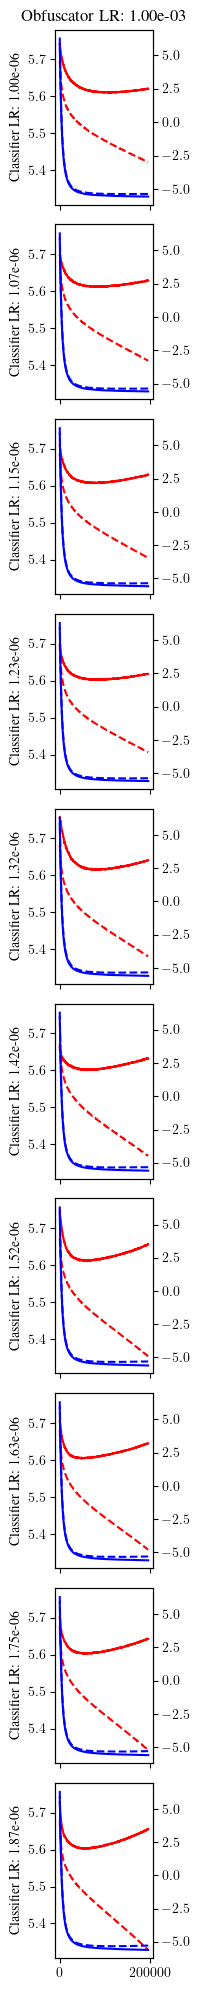

In [94]:
def extract_curve(curve):
    steps = np.array([x.step for x in curve])
    vals = np.array([x.value for x in curve])
    return steps, vals
fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)), sharex=True, sharey=True)
if len(obfuscator_learning_rates) == 1:
    axes = axes[:, np.newaxis]
for c_idx, classifier_lr in enumerate(classifier_learning_rates):
    for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
        for idx in range(result_count):
            if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                ax = axes[c_idx, o_idx]
                tax = ax.twinx()
                training_curves = results['training_curves'][idx]
                ax.plot(*extract_curve(training_curves['classifier_train_loss']), color='red', linestyle='--')
                ax.plot(*extract_curve(training_curves['classifier_val_loss']), color='red', linestyle='-')
                tax.plot(*extract_curve(training_curves['obfuscator_train_loss']), color='blue', linestyle='--')
                tax.plot(*extract_curve(training_curves['obfuscator_val_loss']), color='blue', linestyle='-')
for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
    ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
    ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
fig.tight_layout()

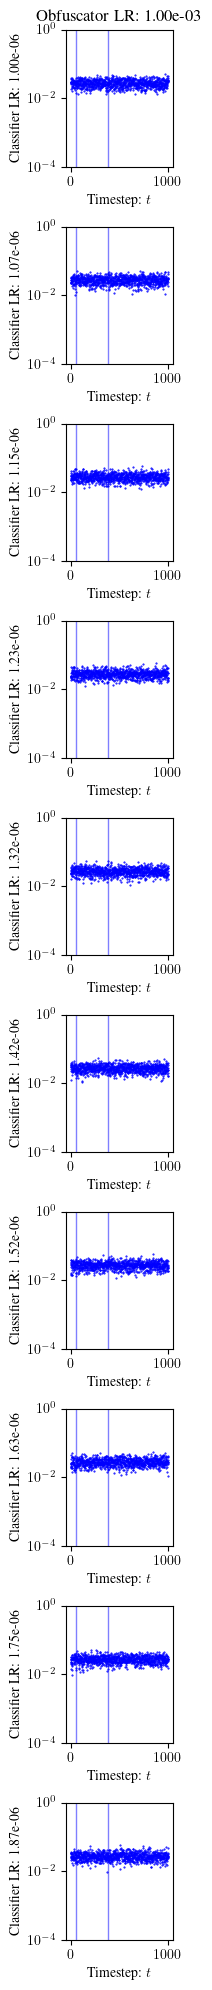

In [95]:
fig, axes = plt.subplots(len(classifier_learning_rates), len(obfuscator_learning_rates), figsize=(2*len(obfuscator_learning_rates), 2*len(classifier_learning_rates)))
if len(obfuscator_learning_rates) == 1:
    axes = axes[:, np.newaxis]
for c_idx, classifier_lr in enumerate(classifier_learning_rates):
    for o_idx, obfuscator_lr in enumerate(obfuscator_learning_rates):
        for idx in range(result_count):
            if (results['classifier_learning_rates'][idx] == classifier_lr) and (results['obfuscator_learning_rates'][idx] == obfuscator_lr):
                ax = axes[c_idx, o_idx]
                for cycle in dataset_summary['leaking_subbytes_cycles']:
                    ax.axvspan(cycle, cycle+dataset_summary['max_no_ops'], color='blue', alpha=0.5, label='ground truth')
                ax.plot(results['erasure_probs'][idx], color='blue', linestyle='none', marker='.', markersize=1.0)
                ax.set_xlabel('Timestep: $t$')
                ax.set_ylabel('Leakage measurement: $\lambda \gamma_t^*$')
                #ax.set_ylim(0, 1)
                ax.set_yscale('log')
                ax.set_ylim(1e-4, 1e0)
for ax, classifier_lr in zip(axes[:, 0], classifier_learning_rates):
    ax.set_ylabel(f'Classifier LR: {classifier_lr:.2e}')
for ax, obfuscator_lr in zip(axes[0, :], obfuscator_learning_rates):
    ax.set_title(f'Obfuscator LR: {obfuscator_lr:.2e}')
fig.tight_layout()